In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import time
import os

rnd = 384
np.random.seed(rnd)

In [2]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/adult_clear.csv')
df = df[df["workclass"] != "?"]
df = df[df["occupation"] != "?"]
df = df[df["native-country"] != "?"]
df.replace(['Divorced', 'Married-AF-spouse',
            'Married-civ-spouse', 'Married-spouse-absent',
            'Never-married', 'Separated', 'Widowed'],
           ['notmarried', 'married', 'married', 'married',
            'notmarried', 'notmarried', 'notmarried'], inplace=True)
df['education'].replace(['Preschool', '10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th'], 'dropout',
                        inplace=True)
df['education'].replace(['HS-Grad', 'HS-grad'], 'HighGrad', inplace=True)
df['education'].replace(['Some-college', 'Assoc-acdm', 'Assoc-voc'], 'CommunityCollege', inplace=True)
df = df[df.race == 'White']
# excludes 10 observations
df = df[df['workclass'] != 'Never-worked']
# excludes 14 observations
df = df[df['occupation'] != 'Armed-Forces']
# excludes 21 observations
df = df[df['workclass'] != 'Without-pay']
df.drop(['fnlwgt', 'educational-num', 'relationship', 'race', 'capital-gain', 'capital-loss'],
            axis=1, inplace=True)
df['workclass'].replace(['Local-gov', 'State-gov', 'Federal-gov'], 'Gov', inplace=True)
df['workclass'].replace(['Private', 'Self-emp-not-inc', 'Self-emp-inc'], 'Private', inplace=True)
df['occupation'].replace(
    ['Craft-repair', 'Machine-op-inspct', 'Handlers-cleaners', 'Transport-moving', 'Adm-clerical',
     'Farming-fishing'], 'BlueCollar', inplace=True)
df['occupation'].replace(['Other-service', 'Protective-serv', 'Tech-support', 'Priv-house-serv'], 'Services',
                         inplace=True)
df['occupation'].replace(['Exec-managerial'], 'ExecManagerial', inplace=True)
df['occupation'].replace(['Prof-specialty'], 'ProfSpecialty', inplace=True)
df['education'].replace(['Prof-school'], 'ProfSchool', inplace=True)
df['native-country'].replace(['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', \
                              'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti',\
                              'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland',\
                              'Italy', 'Jamaica', 'Japan', 'Mexico', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)',\
                              'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South',\
                              'Taiwan','Thailand', 'Trinadad&Tobago', 'Vietnam','Yugoslavia'], 'Non_US', inplace=True)
df.rename(columns={'hours-per-week': 'hoursPerWeek'}, inplace=True)
df.rename(columns={'marital-status': 'marital_status'}, inplace=True)
df.rename(columns={'native-country': 'native_country'}, inplace=True)
columns_titles = ["age","hoursPerWeek","education","marital_status","occupation","gender","native_country","income"]
df=df.reindex(columns=columns_titles)
df = df[~df.duplicated()]
X = df.copy()
enc = OrdinalEncoder()
std = MinMaxScaler(feature_range=(-1,1))
X.iloc[:,2:] = enc.fit_transform(X.values[:,2:]).astype(int)
X.iloc[:,:2] = std.fit_transform(X.values[:,:2])
X.drop(['income'], axis=1, inplace=True)
y = df["income"].apply(lambda x: ">50K" in x).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rnd)

In [3]:
X_train

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country
17534,-0.041096,-0.142857,3,1,0,0,1
14204,-0.342466,-0.040816,3,1,0,1,1
18447,-0.178082,-0.204082,3,0,3,1,1
10398,0.013699,-0.204082,1,1,3,0,1
24516,-0.753425,-0.367347,6,1,2,0,1
...,...,...,...,...,...,...,...
35701,-0.150685,-0.714286,3,1,2,1,1
11005,-0.671233,-0.204082,6,1,0,0,1
952,-0.369863,-0.204082,3,0,0,0,1
47357,-0.095890,0.102041,4,0,3,1,1


In [4]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train.values, y_train.values)
# train model
bst = xgb.train({'objective':'binary:logistic'}, dtrain, 20)
bst.save_model('black_box.bst')

[16:16:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/francescobodria/anaconda3/envs/latent_space/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
def predict(x, return_proba=False):
    if len(x.shape)==1:
        d = xgb.DMatrix(x.reshape(1,-1))
    else:
        d = xgb.DMatrix(x)
    if return_proba:
        return bst.predict(d)
    else: return np.round(bst.predict(d)).astype(int)

In [6]:
dtest = xgb.DMatrix(X_test.values)
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

train acc: 0.7878918254456054
test acc: 0.7647492625368731


In [7]:
X_train = np.hstack((X_train.values,y_train_pred.reshape(-1,1)))
X_test = np.hstack((X_test.values,y_test_pred.reshape(-1,1)))

In [8]:
latent_dim = 2
batch_size = 1024
sigma = 1
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3
idx_cat = [2,3,4,5,6]

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity(X, sigma, idx_cat=None):
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = torch.cdist(X_cont,X_cont)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont
    else:
        D = torch.cdist(X,X)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity(X, sigma, idx_cat)
    Sz = compute_similarity(Z, 1)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [9]:
train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/adult_mixed_dist_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [10]:
model.load_state_dict(torch.load(f'./models/adult_mixed_dist_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

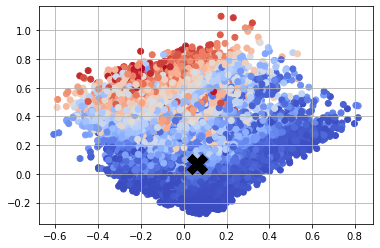

In [11]:
idx = 0
plt.scatter(Z_train[:,0],Z_train[:,1],c=y_train_pred,cmap='coolwarm')
plt.plot(Z_test[idx,0],Z_test[idx,1],'kX',markersize=20)
plt.grid()

In [12]:
idx = 0
predict(X_test[idx:idx+1,:-1],return_proba=True)

array([0.03505402], dtype=float32)

In [13]:
y_contrib = model.fc1.weight.detach().numpy()[:,-1]

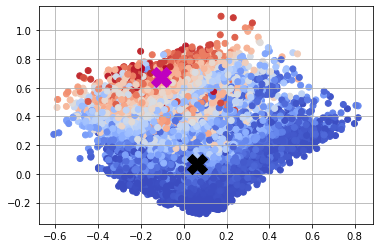

In [14]:
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
plt.plot(Z_test[idx,0], Z_test[idx,1], 'kX', markersize=20)
m = +2
plt.plot(Z_test[idx,0]+m*y_contrib[0], Z_test[idx,1]+m*y_contrib[1], 'mX', markersize=20)
plt.grid()

In [15]:
from scipy.spatial.distance import cdist
neigh = np.argsort(cdist(Z_train,Z_test[idx:idx+1]).ravel())[:10]
predict(X_train[neigh,:-1],return_proba=True)

array([0.28057063, 0.15774645, 0.21404687, 0.10454444, 0.05220185,
       0.28814995, 0.02719215, 0.03031424, 0.04824249, 0.09493919],
      dtype=float32)

In [37]:
from scipy.spatial.distance import cdist
m = +2
neigh = np.argsort(cdist(Z_train,Z_test[idx:idx+1]+m*y_contrib).ravel())[:10]
predict(X_train[neigh,:-1],return_proba=True)

array([0.800528  , 0.5764874 , 0.81812507, 0.74369   , 0.7649184 ,
       0.72940433, 0.6592708 , 0.81812507, 0.6276643 , 0.58063734],
      dtype=float32)

In [38]:
pd.DataFrame(np.vstack((X_test[idx],X_train[neigh])),columns=df.columns)

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country,income
0,-0.534247,-0.653061,0.0,1.0,0.0,1.0,1.0,0.035054
1,-0.095890,0.000000,2.0,0.0,2.0,1.0,1.0,0.800528
2,0.041096,0.204082,0.0,0.0,0.0,1.0,1.0,0.576487
3,-0.123288,0.000000,4.0,0.0,2.0,1.0,1.0,0.818125
4,-0.068493,0.000000,0.0,0.0,1.0,1.0,1.0,0.743690
5,-0.068493,0.102041,4.0,0.0,3.0,1.0,1.0,0.764918
6,-0.041096,0.040816,0.0,0.0,2.0,1.0,1.0,0.729404
7,-0.013699,0.102041,1.0,0.0,1.0,1.0,1.0,0.659271
8,-0.095890,0.000000,4.0,0.0,2.0,1.0,1.0,0.818125
9,0.013699,0.204082,1.0,0.0,1.0,1.0,1.0,0.627664


In [39]:
x = X_train[neigh]
x_cont = x[:,[0,1,7]]
x_cat = x[:,[2,3,4,5,6]]
(5/8)*cdist(X_test[idx:idx+1,[2,3,4,5,6]], x_cat, metric='hamming') + (3/8)*cdist(X_test[idx:idx+1,[0,1,-1]], x_cont, metric='euclidean')

array([[0.78657774, 0.56213854, 0.78725728, 0.65136917, 0.80581075,
        0.6619518 , 0.79102965, 0.79120698, 0.81650175, 0.80789344]])

In [50]:
neigh = np.argsort(cdist(Z_train[y_train_pred>0.5],Z_test[idx:idx+1]).ravel())[:10]
pd.DataFrame(np.vstack((X_test[idx],X_train[y_train_pred>0.5][neigh])),columns=df.columns)

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country,income
0,-0.534247,-0.653061,0.0,1.0,0.0,1.0,1.0,0.035054
1,-0.534247,-0.204082,5.0,1.0,2.0,0.0,1.0,0.538844
2,-0.534247,-0.061224,5.0,1.0,2.0,0.0,1.0,0.550823
3,-0.534247,0.204082,5.0,1.0,2.0,0.0,1.0,0.574973
4,-0.424658,0.000000,5.0,1.0,2.0,0.0,1.0,0.610117
5,-0.397260,0.204082,2.0,1.0,1.0,0.0,0.0,0.545286
6,-0.369863,-0.204082,5.0,1.0,2.0,0.0,1.0,0.559132
7,-0.315068,-0.102041,2.0,1.0,2.0,0.0,1.0,0.532931
8,-0.369863,0.000000,5.0,1.0,2.0,0.0,1.0,0.610117
9,-0.342466,-0.102041,5.0,1.0,2.0,0.0,1.0,0.586528


In [51]:
x = X_train[y_train_pred>0.5][neigh]
x_cont = x[:,[0,1]]
x_cat = x[:,[2,3,4,5,6]]
(5/8)*cdist(X_test[idx:idx+1,[2,3,4,5,6]], x_cat, metric='hamming') + (3/8)*cdist(X_test[idx:idx+1,[0,1]], x_cont, metric='euclidean')

array([[0.54336735, 0.59693878, 0.69642857, 0.62332213, 0.82550759,
        0.55429731, 0.59737928, 0.62753707, 0.59379037, 0.70677073]])

# Lagrange Multipliers

In [52]:
q = X_test[0].copy()
v = np.array(Z_test[idx,:]+m*y_contrib)
v

array([-0.10439104,  0.67729336], dtype=float32)

In [53]:
w = model.fc1.weight.detach().numpy()
b = model.fc1.bias.detach().numpy()
w

array([[ 0.3581095 , -0.26620793,  0.00341975,  0.0993959 ,  0.00262481,
        -0.16217908,  0.04940028, -0.0840246 ],
       [ 0.3340445 ,  0.08518743,  0.0005477 , -0.18182224, -0.00411317,
         0.11448195,  0.04664631,  0.30498004]], dtype=float32)

In [54]:
def compute_cf(q, indexes):
    #indexes.append(-1)
    q_pred = predict(q[:-1],return_proba=True)
    q_cf = q.copy()
    q_cf_pred = predict(q_cf[:-1],return_proba=True)
    while np.round(q_pred) == np.round(q_cf_pred):
        c_l = [v[l] - np.sum(q_cf*w[l,:]) - b[l] for l in range(latent_dim)]
        M = []
        for l in range(latent_dim):
            M.append([np.sum(w[k,indexes]*w[l,indexes]) for k in range(latent_dim)])
        M = np.vstack(M)
        lambda_k = np.linalg.solve(M, c_l)
        delta_i = [np.sum(lambda_k*w[:,i]) for i in indexes]
        print(delta_i)
        q_cf[indexes] += delta_i
        if predict(q_cf[:-1],return_proba=True) == q_cf_pred:
            return q_cf
        q_cf_pred = predict(q_cf[:-1],return_proba=True) 
        print(q_cf_pred)
        q_cf[-1] = q_cf_pred
    return q_cf

In [57]:
idx = 0
q = X_test[idx,:].copy()
q[3] = 0
q_cf = compute_cf(q, [3,5])
q_cf[-1] = predict(q_cf[:-1],return_proba=True) 
print(predict(q_cf[:-1],return_proba=True))
q[3] = 1
pd.DataFrame([q,q_cf], columns = df.columns)


[-3.4003168339919685, -1.660659280089896]
[0.54616076]
[0.54616076]


,age,hoursPerWeek,education,marital_status,occupation,gender,native_country,income
0,-0.534247,-0.653061,0.0,1.000000,0.0,1.000000,1.0,0.035054
1,-0.534247,-0.653061,0.0,-3.400317,0.0,-0.660659,1.0,0.546161


In [82]:
sorted(cdist(X_train[:,:-1], q_cf[:-1].reshape(1,-1)))[0]

array([2.29220706])

In [83]:
np.sum(np.abs(q[:-1]-q_cf[:-1]))

5.986797284334898

# Growing Spheres

In [40]:
from growingspheres import counterfactuals as cf

q = X_test[idx,:-1].reshape(1,-1).copy()
pred = int(predict(q))
print(pred)

CF = cf.CounterfactualExplanation(q, predict, method='GS')
CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=True)
q_cf_GS = CF.enemy
print(predict(q_cf_GS))

0
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  45
Final radius:  (0.8020000000000004, 0.8200000000000004)
Final number of ennemies:  1
Feature selection...
Reduced 5 coordinates
[1]


In [41]:
pd.DataFrame(np.vstack([q,q_cf_GS.reshape(1,-1)]), columns = df.columns[:-1])

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country
0,-0.534247,-0.653061,0.0,1.00000,0.0,1.000000,1.0
1,-0.534247,-0.653061,0.0,0.44423,0.0,0.462684,1.0


In [42]:
sorted(cdist(X_train[:,:-1], q_cf_GS.reshape(1,-1)))[0]

array([0.64504675])

In [48]:
q_cf_GS_cont = q_cf_GS[[0,1]].reshape(1,-1)
q_cf_GS_cat = q_cf_GS[[2,3,4,5,6]].reshape(1,-1)
(5/8)*cdist(X_test[idx:idx+1,[2,3,4,5,6]], q_cf_GS_cat, metric='hamming') + (3/8)*cdist(X_test[idx:idx+1,[0,1]], q_cf_GS_cont, metric='euclidean')

array([[0.25]])